In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
/content/drive/My Drive/CSCB
 20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5
 adHW4_2025.h5ad
 adHW5_EpiMesoAPS_n500.h5ad
'adQuery_n2000_CSCB_HW3 (1).h5ad'
'adTrain_n110_CSCB_HW3 (1).h5ad'
 adValidation_n300_CSCB_HW3.h5ad
 allTFs_mm_aertslab_011924.txt
 Enrichr_CytoTRACE_pseudotime_Early/
 Enrichr_CytoTRACE_pseudotime_Late/
 Enrichr_CytoTRACE_pseudotime_Middle/
 Enrichr_scFates_pseudotime_Early/
 Enrichr_scFates_pseudotime_Late/
 Enrichr_scFates_pseudotime_Middle/
 HW1.ipynb
 HW2.ipynb
 HW3.ipynb
 HW4.ipynb
 HW5.ipynb
 OneSC_network.csv
 pbmc_10k_v3_filtered_feature_bc_matrix.h5
 pySCN_classifier.pkl
 Sample_3.h5
 state_dict.pickle


In [2]:
!pip uninstall genecnv

In [3]:
!pip install git+https://github.com/nik548/cscbfinalprojectS25.git

  Cloning https://github.com/nik548/cscbfinalprojectS25.git to /tmp/pip-req-build-2mvx8_2w
  Running command git clone --filter=blob:none --quiet https://github.com/nik548/cscbfinalprojectS25.git /tmp/pip-req-build-2mvx8_2w
  Resolved https://github.com/nik548/cscbfinalprojectS25.git to commit e9c70dd6b5b580a492ab6f80932a38f375c342ff
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.0 MB/s eta 0:00:00
  Created wheel for genecnv: filename=genecnv-0.1.0-py3-none-any.whl size

In [4]:
import genecnv as genecnv

In [5]:
from genecnv import run_adaptive_cnv_pipeline, annotate_cnv_calls, annotate_genes_mygene, preprocess

In [6]:
!pip install scanpy python-igraph scipy anndata

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.metrics import f1_score
import seaborn as sns
from typing import List, Dict, Optional, Tuple
from scipy.stats import zscore
from scipy.sparse import csr_matrix, issparse

In [8]:
data = ad.read_h5ad('/content/drive/MyDrive/CSCB_Final/Data/PBMC_simulated_cnas_041025.h5ad')

In [9]:
# ──────────────────────────────────────────────────────────────────────────────
# Example usage:
# ──────────────────────────────────────────────────────────────────────────────
# Load or create an AnnData object (adata)
adata = ad.read_h5ad('/content/drive/MyDrive/CSCB_Final/Data/PBMC_simulated_cnas_041025.h5ad')

# (Optional) Annotate genes if coordinates missing
adata = annotate_genes_mygene(adata)

# (Optional) Clean data
adata_clean = preprocess(adata,  allowed_chromosomes=['6', '22'] + ['X'])

# Using optimal hyperparameters obtained via tuning
adata_with_calls, bins, centers, calls = run_adaptive_cnv_pipeline(
    adata_clean,
    cell_type_key='cell_type',
    target_genes_per_bin=100,
    decay_scale=1e6,
    decay_radius=10,
    reference_frac=0.15,
    min_run=3,
    n_cells = None
)
# Then call annotation:
annotate_cnv_calls(adata_with_calls, calls, bins, centers, test = True)

INFO:biothings.client:querying 1-411 ...


Querying MyGene.info for 411 genes...


INFO:biothings.client:Finished.


After query, 358 genes remain un-annotated.
Dropped 358 genes without coordinates.
[QC] Filtered to 10259 cells
[QC] Retained 19425 genes after min_cells_per_gene=3
[QC] Retained 1991 genes with genomic coords
[Norm] Scaled to 10000.0 counts per cell
[Norm] Applied log1p
[Preprocess] Completed: 10259 cells × 1991 genes


In [12]:
import re

def compute_metrics(
    adata: sc.AnnData,
    gt_col: str,
    pred_col: str,
    overlap_fraction: float = 0.5
) -> pd.DataFrame:
    """
    Compute cell‑level confusion metrics by matching predicted vs. ground‑truth CNV regions,
    and return them as a 1‑row pandas DataFrame.

    Parameters
    ----------
    adata
        AnnData with CNV region strings in obs[gt_col] and obs[pred_col].
    gt_col, pred_col : str
        Column names in adata.obs for ground‑truth and predicted region annotations.
    overlap_fraction : float
        Minimum fraction of a ground‑truth segment that must be overlapped by a prediction
        (on the same chromosome) to count as a true positive.

    Returns
    -------
    pd.DataFrame
        One‑row table with columns [accuracy, precision, recall, specificity, TP, TN, FP, FN].
    """
    pattern = re.compile(r"([0-9XY]+):([0-9,]+)-([0-9,]+)")
    def parse(txt):
        out = []
        for m in pattern.finditer(txt or ""):
            chrom, s, e = m.groups()
            out.append((chrom, int(s.replace(",","")), int(e.replace(",",""))))
        return out

    TP = TN = FP = FN = 0
    for cell in adata.obs_names:
        gt = parse(adata.obs.at[cell, gt_col] or "")
        pr = parse(adata.obs.at[cell, pred_col] or "")
        pred_pos = len(pr) > 0
        truth_pos = True

        # require every GT interval to find a matching PR interval
        for cg, sg, eg in gt:
            matched = False
            length = eg - sg
            if length <= 0:
                truth_pos = False
                break
            for cp, sp, ep in pr:
                if cp != cg:
                    continue
                overlap = max(0, min(ep, eg) - max(sp, sg))
                if overlap / length >= overlap_fraction:
                    matched = True
                    break
            if not matched:
                truth_pos = False
                break

        if truth_pos and pred_pos:
            TP += 1
        elif not truth_pos and not pred_pos:
            TN += 1
        elif not truth_pos and pred_pos:
            FP += 1
        elif truth_pos and not pred_pos:
            FN += 1

    total = TP + TN + FP + FN
    acc = (TP + TN) / total if total else np.nan
    prec = TP / (TP + FP) if (TP + FP) else 0.0
    rec = TP / (TP + FN) if (TP + FN) else 0.0
    spec = TN / (TN + FP) if (TN + FP) else 0.0

    # return as a table
    return pd.DataFrame([{
        'accuracy':    acc,
        'precision':   prec,
        'recall':      rec,
        'specificity': spec,
        'TP':          TP,
        'TN':          TN,
        'FP':          FP,
        'FN':          FN
    }])




,accuracy,precision,recall,specificity,TP,TN,FP,FN
0,0.705624,0.785634,0.788298,0.521835,5578,1661,1522,1498


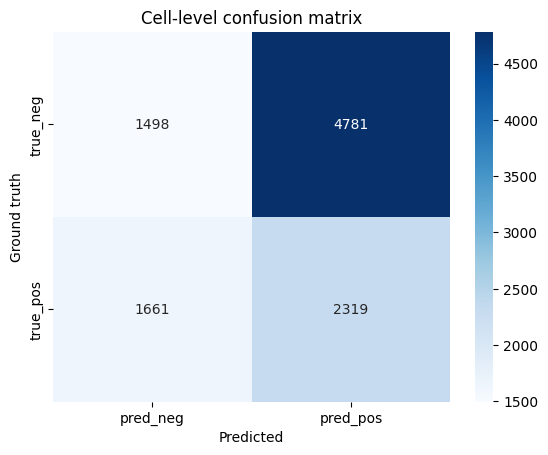

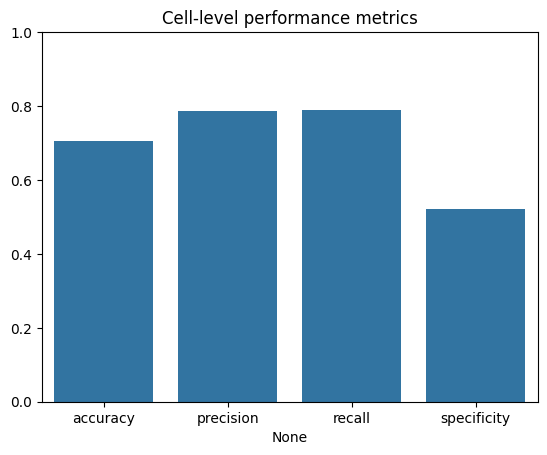

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

metrics = compute_metrics(adata_with_calls, 'simulated_cnvs', 'cnv_regions')
display(metrics)


# 2) build y_true / y_pred boolean vectors properly
#    A cell is “positive” if its CNV‐string is non‐empty
y_true = adata_with_calls.obs['simulated_cnvs'].fillna("").map(lambda s: len(s)>0).values
y_pred = adata_with_calls.obs['cnv_regions'].fillna("").map(lambda s: len(s)>0).values

# 3) confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['pred_neg','pred_pos'],
            yticklabels=['true_neg','true_pos'])
plt.xlabel('Predicted')
plt.ylabel('Ground truth')
plt.title('Cell‑level confusion matrix')
plt.show()

# 4) bar‑plot of the four metrics
metrics = df.iloc[0][['accuracy','precision','recall','specificity']]
sns.barplot(x=metrics.index, y=metrics.values)
plt.ylim(0,1)
plt.title('Cell‑level performance metrics')
plt.show()


Our method performs moderately well in terms of accuracy, precision and recall. The specificity isn't that great as our method tends to overcall CNVs (i.e., more predicted postives then we would like), but this is something we can continue to work on in the future.